## Importing Library and data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['AirPassengers.csv']


In [3]:
data = pd.read_csv('../input/AirPassengers.csv',  index_col='Month',  parse_dates = ['Month'])

In [4]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
data.dtypes

#Passengers    int64
dtype: object

In [6]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

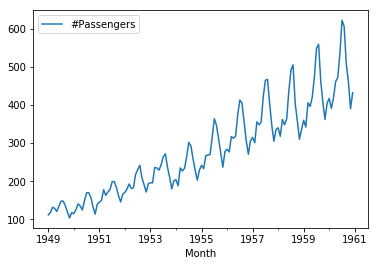

In [7]:
data.plot()

### Time series analysis

In [8]:
ts = data["#Passengers"] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [9]:
ts[datetime(1949,8,1)]

148

In [10]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

## Stationarty Check

What is stationary process?

- Mean = constant over all intervals.
- Variance = constant over all intervals.

## Dickey Fuller Test

Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the Test Statistic is less than the Critical Value, we can reject the null hypothesis and say that the series is stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(8,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


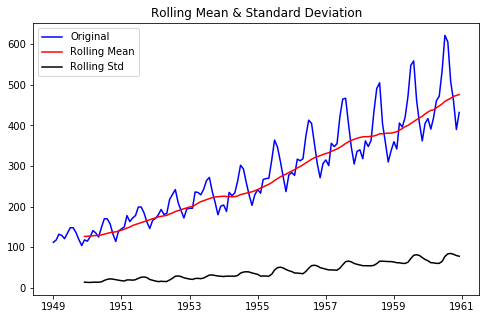

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(ts)

Therefore, the time series is not stationary.

There are 2 major reasons behind non-stationaruty of a TS:

1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

 2.** Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

### Using Log to eliminate Trend

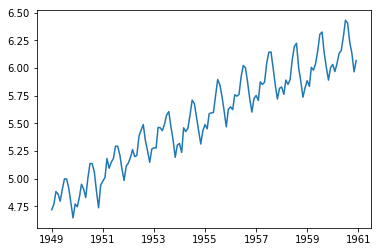

In [13]:
ts_log = np.log(ts)
plt.plot(ts_log)

We will deal with the noise by taking rolling mean i.e. smoothing

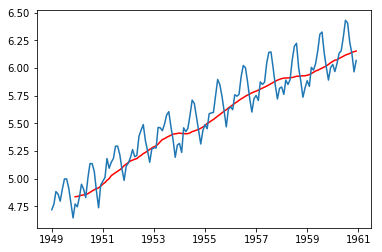

In [14]:
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()

#### Case 1 : No subtraction

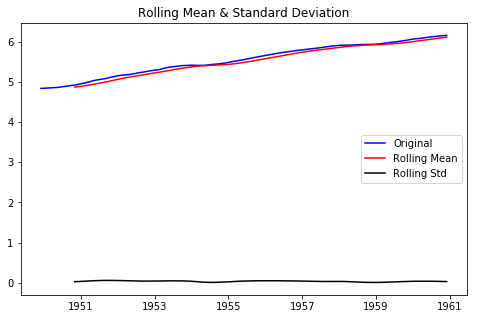

Results of Dickey-Fuller Test:
Test Statistic                  -1.737158
p-value                          0.412076
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [15]:
no_sub_ts = ts_smooth
no_sub_ts.dropna(inplace = True)
test_stationarity(no_sub_ts)

#### Case 2: Subtraction

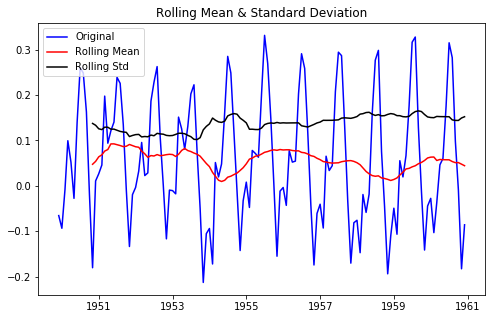

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)
test_stationarity(sub_ts)

### Exponential weighted average 

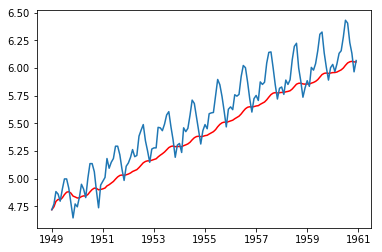

In [17]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(expwighted_avg, color='red')
plt.plot(ts_log)

#### Case 1: No Subtraction

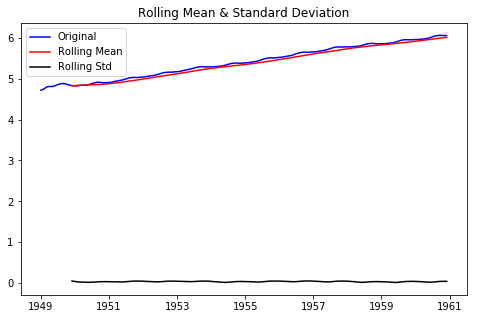

Results of Dickey-Fuller Test:
Test Statistic                  -2.148248
p-value                          0.225561
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [18]:
no_sub_ts = expwighted_avg
no_sub_ts.dropna(inplace = True)
test_stationarity(no_sub_ts)

#### Case 2: Subtraction

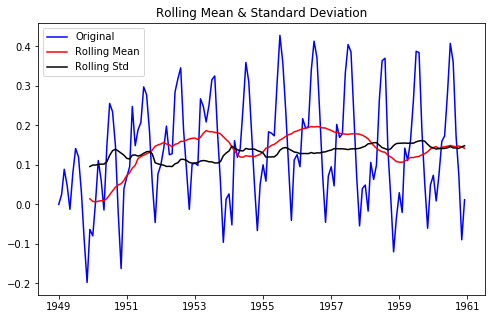

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [19]:
exp_ts_diff = ts_log-expwighted_avg
exp_ts_diff.dropna(inplace = True)
test_stationarity(exp_ts_diff)


We are 99% sure that we have a stationary series.

## Differencing

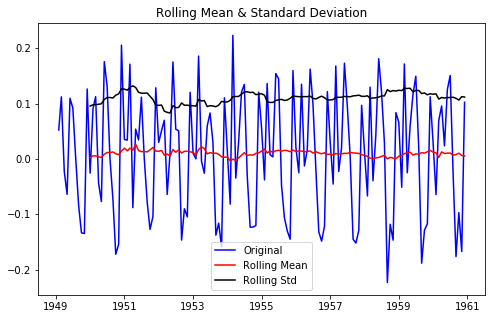

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)
test_stationarity(ts_diff)

#### Differencing + Exponential weighting

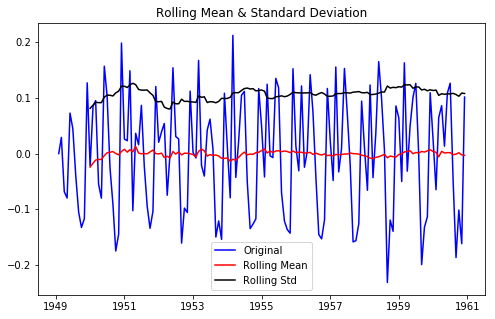

Results of Dickey-Fuller Test:
Test Statistic                  -4.067811
p-value                          0.001094
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [21]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

## Decomposition

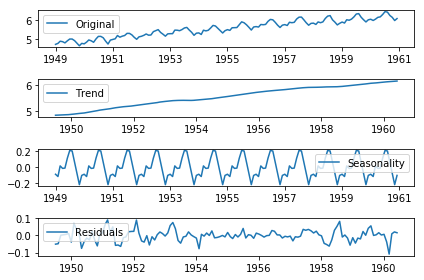

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

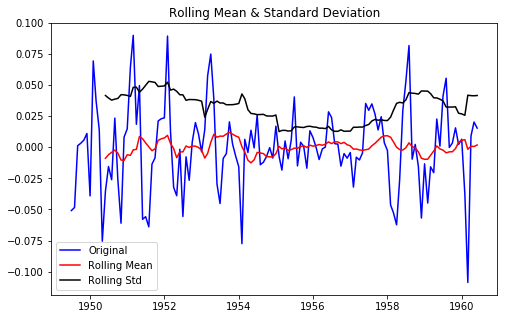

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [23]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Forecasting

Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case.

### ARIMA model

In [29]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5,1,'Autocorrelation Function')

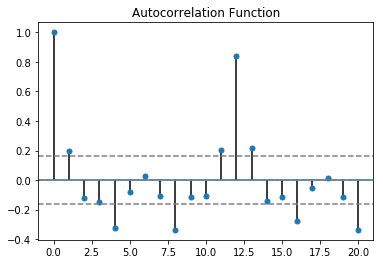

In [32]:
plot_acf(ts_diff,lags=20,alpha=1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


Text(0.5,1,'Partial Autocorrelation Function')

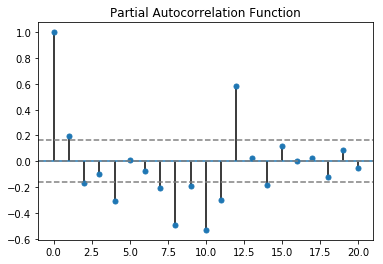

In [33]:
plot_pacf(ts_diff,lags=20,alpha=1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

p = 2, q = 2

Now AR, MA & ARIMA models for the data

In [34]:
from statsmodels.tsa.arima_model import ARMA
mod = ARMA(ts_diff, order=(1,0))
res = mod.fit()
print("The AIC for an AR(1) is: ", res.aic)

# Fit the data to an AR(2) model and print AIC:
mod = ARMA(ts_diff, order=(2,0))
res = mod.fit()
print("The AIC for an AR(2) is: ", res.aic)

mod = ARMA(ts_diff, order=(3,0))
res = mod.fit()
print("The AIC for an AR(3) is: ", res.aic)

# Fit the data to an MA(1) model and print AIC:
mod = ARMA(ts_diff, order=(0,1))
res = mod.fit()
print("The AIC for an MA(1) is: ", res.aic)

mod = ARMA(ts_diff, order=(0,2))
res = mod.fit()
print("The AIC for an MA(2) is: ", res.aic)

mod = ARMA(ts_diff, order=(0,3))
res = mod.fit()
print("The AIC for an MA(3) is: ", res.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod = ARMA(ts_diff, order=(1,1))
res = mod.fit()
print("The AIC for an ARMA(1,1) is: ", res.aic)

mod = ARMA(ts_diff, order=(2,2))
res = mod.fit()
print("The AIC for an ARMA(2,2) is: ", res.aic)

mod = ARMA(ts_diff, order=(3,3))
res = mod.fit()
print("The AIC for an ARMA(3,3) is: ", res.aic)

The AIC for an AR(1) is:  -235.38589888263135
The AIC for an AR(2) is:  -237.6046356975284
The AIC for an AR(3) is:  -236.95178478978522
The AIC for an MA(1) is:  -237.5073149855421
The AIC for an MA(2) is:  -240.3789540202477
The AIC for an MA(3) is:  -257.8902625951644
The AIC for an ARMA(1,1) is:  -241.60771402612232
The AIC for an ARMA(2,2) is:  -287.2808079212986
The AIC for an ARMA(3,3) is:  -289.4747225981437


In [35]:
model=pd.DataFrame()
names=['AR(1)','AR(2)','AR(3)','MA(1)','MA(2)','MA(3)','ARMA(1,1)','ARMA(2,2)','ARMA(3,3)']
aic=[-235.38589888263135,-237.6046356975284,-236.95178478978522,-237.5073149855421,-240.3789540202477,-257.8902625951644,-241.60771402612232,-287.2808079212986,-289.4747225981437]
model['Model Name']=names
model['AIC']=aic
model=model.set_index('Model Name')
model

,AIC
Model Name,
AR(1),-235.385899
AR(2),-237.604636
AR(3),-236.951785
MA(1),-237.507315
MA(2),-240.378954
MA(3),-257.890263
"ARMA(1,1)",-241.607714
"ARMA(2,2)",-287.280808
"ARMA(3,3)",-289.474723


#### AR(2) Model

Text(0.5,1,'RSS: 1.5023')

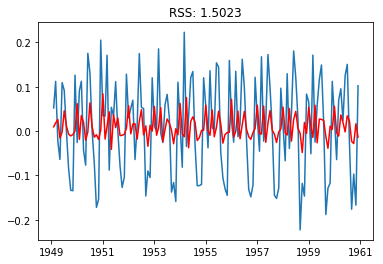

In [37]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

#### MA(2) Model

Text(0.5,1,'RSS: 1.4721')

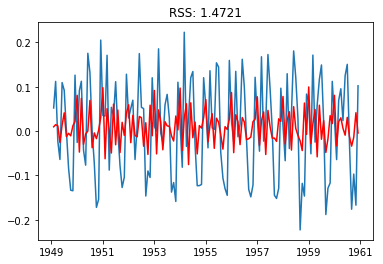

In [38]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

#### ARIMA(2,1,2)

Text(0.5,1,'RSS: 1.0292')

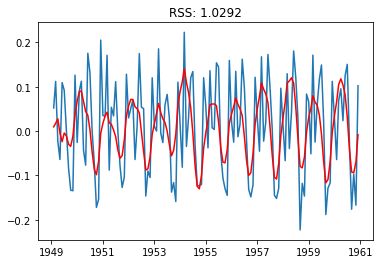

In [39]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [40]:
preds = pd.Series(results_AR.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print (preds_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [41]:
preds_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
preds_log = preds_log.add(preds_cumsum,fill_value=0)
preds_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5,1,'RMSE: 90.1050')

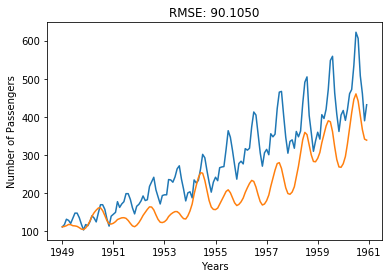

In [42]:
preds_ARIMA = np.exp(preds_log)
plt.plot(ts)
plt.plot(preds_ARIMA)
plt.xlabel('Years')
plt.ylabel("Number of Passengers")
plt.title('RMSE: %.4f'% np.sqrt(sum((preds_ARIMA-ts)**2)/len(ts)))

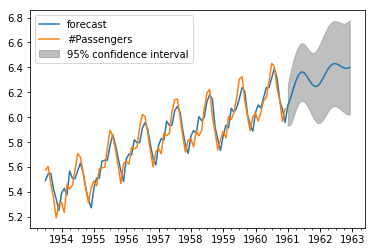

In [43]:
results_AR.plot_predict(start='1953-07-01', end='1962-12-01')
plt.show()

### ARIMA(1,1,1)

Text(0.5,1,'RSS: 1.4597')

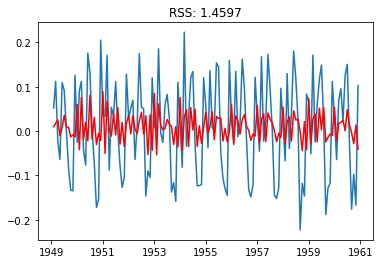

In [44]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_AR_3 = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR_3.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_3.fittedvalues-ts_diff)**2))

In [45]:
preds = pd.Series(results_AR_3.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print (preds_cumsum.head())

Month
1949-02-01    0.009800
1949-03-01    0.027418
1949-04-01    0.052648
1949-05-01    0.042422
1949-06-01    0.050950
dtype: float64


In [46]:
preds_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
preds_log = preds_log.add(preds_cumsum,fill_value=0)
preds_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728299
1949-03-01    4.745917
1949-04-01    4.771146
1949-05-01    4.760921
dtype: float64

Text(0.5,1,'RMSE: 52.4891')

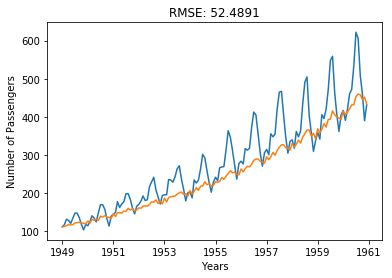

In [47]:
preds_ARIMA = np.exp(preds_log)
plt.plot(ts)
plt.plot(preds_ARIMA)
plt.xlabel('Years')
plt.ylabel("Number of Passengers")
plt.title('RMSE: %.4f'% np.sqrt(sum((preds_ARIMA-ts)**2)/len(ts)))

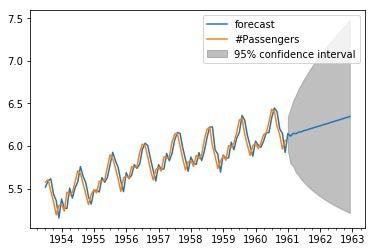

In [48]:
results_AR_3.plot_predict(start='1953-07-01', end='1962-12-01')
plt.show()

This is overfitting the data.